# Comparing the Dynamics of Regular and Mass-Conserved FitzHugh–Nagumo Systems

**Motivation:**  
The FitzHugh–Nagumo (FHN) model is widely used for excitable dynamics with applications in biology and chemistry. Recently, active matter studies have highlighted the role of non-reciprocal energy injection and mass conservation. In this notebook we:
 
1. **Formulate the Models:** Define the regular FHN system and a mass‑conserved version.
2. **Local Dynamics Analysis:** Perform a linear stability analysis of the homogeneous steady states for both systems to reveal differences in stability and bifurcation behavior.
3. **Spatial Pattern Formation:** Use finite‑difference simulations to explore wave propagation, pattern formation, and the influence of the conservation law.
 
---
 
**Main Equations:**
 
**Regular FHN System:**
   $$
   \begin{aligned}
      \frac{\partial u}{\partial t} &= f(u,v) + D_u \nabla^2 u,\\[1mm]
      \frac{\partial v}{\partial t} &= \epsilon\, g(u,v) + D_v \nabla^2 v,
   \end{aligned}
   $$ 
   with
   $$ 
   
     f(u,v) = u-\frac{u^3}{3} - v,\quad 
     g(u,v)= u + a - b\,v.
   $$
 
**Mass-Conserved FHN System:**
   $$
   \begin{aligned}
      \frac{\partial u}{\partial t} &= -\nabla^2\Bigl[f(u,v) + D_u \nabla^2 \Bigr],\\[1mm]
      \frac{\partial v}{\partial t} &= -\nabla^2\Bigl[\epsilon\, g(u,v) + D_v \nabla^2 v\Bigr].
   \end{aligned}
   $$
 
In the following sections we implement and analyze these two models.

We use a finite‑difference scheme (with periodic boundary conditions) and a forward‑Euler time integrator.  

The parameters have been chosen to accentuate differences in spatial behavior between the two models. Experiment with the parameters (e.g. domain size, diffusion coefficients, or reaction parameters) to see more pronounced differences.

## 1. Model Formulation and Function Definitions

We define helper functions for the kinetics, the Laplacian (with periodic boundary conditions), and a plotting function.


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.sparse import diags, csr_matrix

Computational Helpers

In [7]:
def laplacian_1d(n, dx, sparse=True):
    """
    Construct the 1D Laplacian matrix with Dirichlet or periodic BCs.
    """
    if sparse:
        diagonals = [np.ones(n-1), -2*np.ones(n), np.ones(n-1)]
        offsets = [-1, 0, 1]
        L = diags(diagonals, offsets, shape=(n, n), format='csr')
        return L / dx**2
    else:
        L = np.zeros((n, n))
        for i in range(n):
            if i > 0:
                L[i, i-1] = 1
            L[i, i] = -2
            if i < n-1:
                L[i, i+1] = 1
        return L / dx**2


def build_neighbors(n, bc='periodic'):
    """
    Build neighbor indices for an n x n grid, flattening into length-n^2 vectors.
    bc: 'periodic' or 'neumann'
    Returns:
      neighbors: shape (4, n^2) array of up, down, left, right indices
      multiplier: length-n^2 array of neighbor counts
    """
    N = n*n
    neighbors = np.zeros((4, N), dtype=int)
    multiplier = np.full(N, 4, dtype=int)
    for idx in range(N):
        i, j = divmod(idx, n)
        # up
        if i > 0:
            up = (i-1)*n + j
        elif bc == 'periodic':
            up = (n-1)*n + j
        else:
            up = N  # ghost node
            multiplier[idx] -= 1
        # down
        if i < n-1:
            down = (i+1)*n + j
        elif bc == 'periodic':
            down = j
        else:
            down = N
            multiplier[idx] -= 1
        # left
        if j > 0:
            left = i*n + (j-1)
        elif bc == 'periodic':
            left = i*n + (n-1)
        else:
            left = N
            multiplier[idx] -= 1
        # right
        if j < n-1:
            right = i*n + (j+1)
        elif bc == 'periodic':
            right = i*n
        else:
            right = N
            multiplier[idx] -= 1
        neighbors[:, idx] = [up, down, left, right]
    return neighbors, multiplier


def f(u, v):
    return u - (u**3)/3 - v


def g(u, v, a, b):
    return u + a - b*v


def plot_field(ax, X, Y, field, label):
    p = ax.pcolormesh(X, Y, field, shading='auto', cmap='inferno')
    cbar = plt.colorbar(p, ax=ax)
    ax.set_xlabel('x'); ax.set_ylabel('y'); cbar.set_label(label)
    return p

## 2. Local Dynamics Analysis: Homogeneous Steady States and Linear Stability

For homogeneous (spatially constant) solutions the diffusion terms vanish. The fixed point (FP)
must satisfy:

\begin{aligned}
f(u, v) &= u-\frac{u^3}{3} - v = 0,\\[1mm]
g(u, v) &= u + a - b\,v = 0.
\end{aligned}

Eliminating $v$ (i.e. $v = u - \frac{u^3}{3}$) $$ in the second equation leads to the cubic:
$$
\frac{b}{3}u^3 + (1 - b) u + a = 0.
$$
We use `np.roots` to solve this cubic and then compute the corresponding \(v\) values.
 
The Jacobian for the regular FHN (reaction part) is:

$$
J = \begin{pmatrix}
1-u^2 & -1\\[1mm]
\epsilon & -\epsilon\,b
\end{pmatrix}.
$$

The eigenvalues of \(J\) determine the local stability of the FP. For the mass‑conserved system, the
homogeneous FP are the same (the diffusion terms vanish), but spatial perturbations with nonzero wavenumbers alter the stability.

In [8]:
def steady_state_fp(a, b):
    coeffs = [b/3, 0, (1-b), a]
    roots = np.roots(coeffs)
    u_fp = np.real(roots[np.isclose(np.imag(roots), 0)])
    v_fp = u_fp - (u_fp**3)/3
    return u_fp, v_fp


def jacobian(u_fp, epsilon, b):
    return np.array([[1 - u_fp**2, -1], [epsilon, -epsilon*b]])


def analyze_fp(a, b, epsilon):
    u_vals, v_vals = steady_state_fp(a, b)
    print('Fixed Points (u, v):')
    for u_fp, v_fp in zip(u_vals, v_vals):
        print(f'u = {u_fp:.4f}, v = {v_fp:.4f}')
        J = jacobian(u_fp, epsilon, b)
        eigs = np.linalg.eigvals(J)
        print('Eigenvalues:', eigs, '\n')


def dispersion_reg(k, u_fixed, epsilon, b, Du, Dv):
    J = np.array([[1 - u_fixed**2 - Du*k**2, -1],
                  [epsilon, -epsilon*b - Dv*k**2]])
    return np.max(np.linalg.eigvals(J).real)


def dispersion_mc(k, u_fixed, epsilon, b, Du, Dv):
    J = np.array([[k**2*(1 - u_fixed**2) - Du*k**4, -k**2],
                  [epsilon*k**2, -epsilon*b*k**2 - Dv*k**4]])
    return np.max(np.linalg.eigvals(J).real)

In [9]:
# Example parameters for local analysis:
a = 1.1
b = 0.8
epsilon = 0.02
analyze_fp(a, b, epsilon)

Fixed Points (u, v):
u = -1.4484, v = -0.4355
Eigenvalues: [-1.07911401 -0.03481266] 



## 3. Spatial Pattern Formation: Simulations
 
We now simulate the spatially-extended versions of the systems by discretizing space (using finite differences) and time (using a forward-Euler scheme).
 
The following functions implement:
 
**Regular FHN:**
$$
   \begin{aligned}
   \partial_t u &= f(u,v) + D_u \nabla^2u,\\[1mm]
   \partial_t v &= \epsilon\,g(u,v) + D_v \nabla^2v,
   \end{aligned}
$$

 
**Mass-Conserved FHN:**
$$
   \begin{aligned}
   \partial_t u &= -\nabla^2\Bigl[f(u,v)+D_u \nabla^2u\Bigr],\\[1mm]
   \partial_t v &= -\nabla^2\Bigl[\epsilon\,g(u,v)+D_v \nabla^2v\Bigr].
   \end{aligned}
$$
 
You can choose which system to simulate by uncommenting the corresponding block.


In [10]:
def simulate_regular_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv, bc='periodic'):
    x_min, x_max = domain
    x = np.linspace(x_min, x_max, n_space)
    y = np.linspace(x_min, x_max, n_space)
    X, Y = np.meshgrid(x, y)
    dx = (x_max - x_min) / n_space
    n_t = int(T/dt)
    nbrs, mult = build_neighbors(n_space, bc)
    u_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    v_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    for _ in range(n_t):
        u_curr = u_list[-1]; v_curr = v_list[-1]
        uf = u_curr.ravel(); vf = v_curr.ravel()
        u_ext = np.concatenate([uf, [0.]])
        v_ext = np.concatenate([vf, [0.]])
        Lu = (u_ext[nbrs].sum(axis=0) - mult*uf) / dx**2
        Lv = (v_ext[nbrs].sum(axis=0) - mult*vf) / dx**2
        Lu = Lu.reshape((n_space, n_space)); Lv = Lv.reshape((n_space, n_space))
        u_next = u_curr + dt*(f(u_curr, v_curr) + Du*Lu)
        v_next = v_curr + dt*(epsilon*g(u_curr, v_curr, a, b) + Dv*Lv)
        u_list.append(u_next); v_list.append(v_next)
    t_vec = np.linspace(0, T, n_t+1)
    return X, Y, t_vec, np.array(u_list), np.array(v_list)

In [13]:
def simulate_mass_conserved_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv, bc='periodic'):
    x_min, x_max = domain
    x = np.linspace(x_min, x_max, n_space)
    y = np.linspace(x_min, x_max, n_space)
    X, Y = np.meshgrid(x, y)
    dx = (x_max - x_min) / n_space
    n_t = int(T/dt)
    nbrs, mult = build_neighbors(n_space, bc)
    u_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    v_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    for _ in range(n_t):
        u_curr = u_list[-1]; v_curr = v_list[-1]
        uf = u_curr.ravel(); vf = v_curr.ravel()
        u_ext = np.concatenate([uf, [0.]])
        v_ext = np.concatenate([vf, [0.]])
        Lu = (u_ext[nbrs].sum(axis=0) - mult*uf) / dx**2
        Lv = (v_ext[nbrs].sum(axis=0) - mult*vf) / dx**2
        inner_u = f(u_curr, v_curr) + Du*Lu.reshape((n_space, n_space))
        inner_v = epsilon*g(u_curr, v_curr, a, b) + Dv*Lv.reshape((n_space, n_space))
        iu = inner_u.ravel(); iv = inner_v.ravel()
        iu_ext = np.concatenate([iu, [0.]])
        iv_ext = np.concatenate([iv, [0.]])
        L_inner_u = (iu_ext[nbrs].sum(axis=0) - mult*iu) / dx**2
        L_inner_v = (iv_ext[nbrs].sum(axis=0) - mult*iv) / dx**2
        u_next = u_curr - dt*L_inner_u.reshape((n_space, n_space))
        v_next = v_curr - dt*L_inner_v.reshape((n_space, n_space))
        u_list.append(u_next); v_list.append(v_next)
    t_vec = np.linspace(0, T, n_t+1)
    return X, Y, t_vec, np.array(u_list), np.array(v_list)


In [14]:
def simulate_regular_fhn_noise(T, dt, n_space, domain, a, b, epsilon, Du, Dv, sigma, bc='periodic'):
    X, Y, t_vec, _, _ = simulate_regular_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv, bc)
    dx = (domain[1] - domain[0]) / n_space
    n_t = len(t_vec) - 1
    nbrs, mult = build_neighbors(n_space, bc)
    u_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    v_list = [0.1 + 0.01 * np.random.randn(n_space, n_space)]
    for _ in range(n_t):
        u_curr = u_list[-1]; v_curr = v_list[-1]
        uf = u_curr.ravel(); vf = v_curr.ravel()
        u_ext = np.concatenate([uf, [0.]])
        v_ext = np.concatenate([vf, [0.]])
        Lu = (u_ext[nbrs].sum(axis=0) - mult*uf) / dx**2
        Lv = (v_ext[nbrs].sum(axis=0) - mult*vf) / dx**2
        inner_u = f(u_curr, v_curr) + Du*Lu.reshape((n_space, n_space))
        inner_v = epsilon*g(u_curr, v_curr, a, b) + Dv*Lv.reshape((n_space, n_space))
        iu = inner_u.ravel(); iv = inner_v.ravel()
        iu_ext = np.concatenate([iu, [0.]])
        iv_ext = np.concatenate([iv, [0.]])
        L_inner_u = (iu_ext[nbrs].sum(axis=0) - mult*iu) / dx**2
        L_inner_v = (iv_ext[nbrs].sum(axis=0) - mult*iv) / dx**2
        u_next = u_curr - dt*L_inner_u.reshape((n_space, n_space)) + sigma*np.sqrt(dt)*np.random.randn(n_space, n_space)
        v_next = v_curr - dt*L_inner_v.reshape((n_space, n_space)) + sigma*np.sqrt(dt)*np.random.randn(n_space, n_space)
        u_list.append(u_next); v_list.append(v_next)
    return X, Y, t_vec, np.array(u_list), np.array(v_list)


## 4. Visualization

We now compare snapshots of the fields (activator u and inhibitor v) and animate the evolution of u for both models.

In [40]:
# 1) Regular vs Mass-Conserved Comparison
T, dt, n_space = 100, 0.01, 50
domain = (0, 100)
a, b, epsilon = 0.7, 1.0, 0.02
Du, Dv = 1.0, 5.0
X_reg, Y_reg, t_reg, u_reg, v_reg = simulate_regular_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv)
X_mc, Y_mc, t_mc, u_mc, v_mc = simulate_mass_conserved_fhn(T, dt, n_space, domain, a, b, epsilon, Du, Dv)

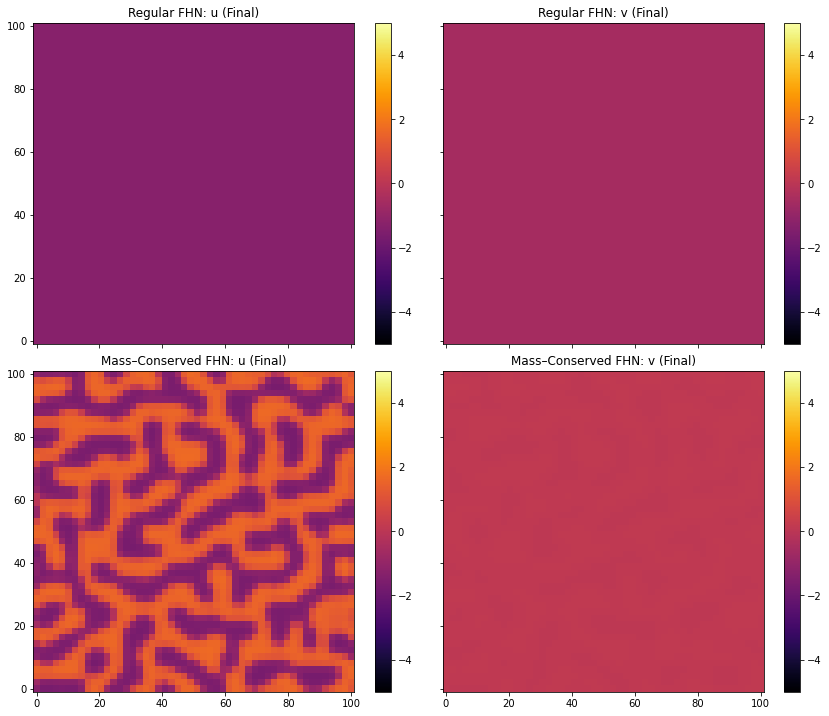

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)

# fixed color limits
cmin, cmax = -5, 5

# top‐left: u (regular)
p = axes[0,0].pcolormesh(
    X_reg, Y_reg, u_reg[-1],
    shading='auto', cmap='inferno',
    vmin=cmin, vmax=cmax
)
axes[0,0].set_title('Regular FHN: u (Final)')

# top‐right: v (regular)
p = axes[0,1].pcolormesh(
    X_reg, Y_reg, v_reg[-1],
    shading='auto', cmap='inferno',
    vmin=cmin, vmax=cmax
)
axes[0,1].set_title('Regular FHN: v (Final)')

# bottom‐left: u (mass‐conserved)
p = axes[1,0].pcolormesh(
    X_mc, Y_mc, u_mc[-1],
    shading='auto', cmap='inferno',
    vmin=cmin, vmax=cmax
)
axes[1,0].set_title('Mass–Conserved FHN: u (Final)')

# bottom‐right: v (mass‐conserved)
p = axes[1,1].pcolormesh(
    X_mc, Y_mc, v_mc[-1],
    shading='auto', cmap='inferno',
    vmin=cmin, vmax=cmax
)
axes[1,1].set_title('Mass–Conserved FHN: v (Final)')

for ax in axes.flat:
    ax.set_aspect('equal')
    plt.colorbar(p, ax=ax)

plt.tight_layout()
plt.show()


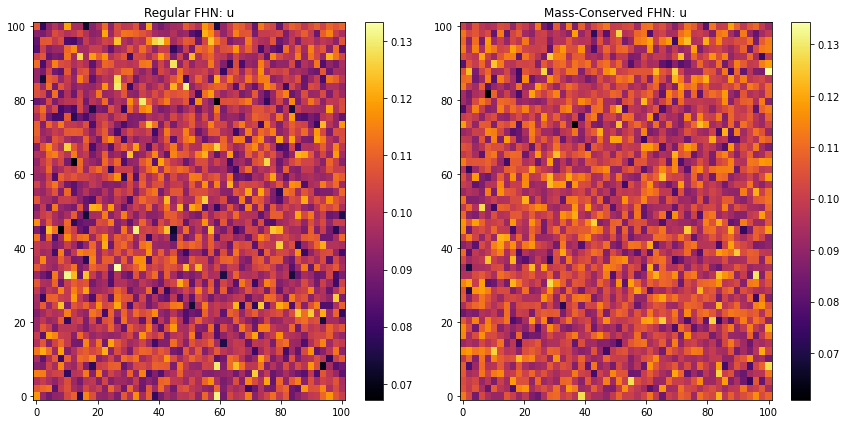

In [19]:
# Animation
fig2, (axr, axm) = plt.subplots(1, 2, figsize=(12,6))
pr = axr.pcolormesh(X_reg, Y_reg, u_reg[0], shading='auto', cmap='inferno'); axr.set_title('Regular FHN: u')
pm = axm.pcolormesh(X_mc, Y_mc, u_mc[0], shading='auto', cmap='inferno'); axm.set_title('Mass-Conserved FHN: u')
fig2.colorbar(pr, ax=axr); fig2.colorbar(pm, ax=axm)

def update(frame):
    pr.set_array(u_reg[frame][:-1, :-1].ravel())
    pm.set_array(u_mc[frame][:-1, :-1].ravel())
    axr.set_title(f'Regular FHN: u, t={t_reg[frame]:.2f}')
    axm.set_title(f'Mass-Conserved FHN: u, t={t_mc[frame]:.2f}')
    return pr, pm

ani = FuncAnimation(fig2, update, frames=len(t_reg), interval=100, blit=False)
plt.tight_layout(); plt.show()

#ani.save("fhn_comparison.mp4", writer="ffmpeg", fps=10)

Fixed Points (u, v):
u = -1.2806, v = -0.5806
Eigenvalues: [-0.60573804 -0.05414496] 



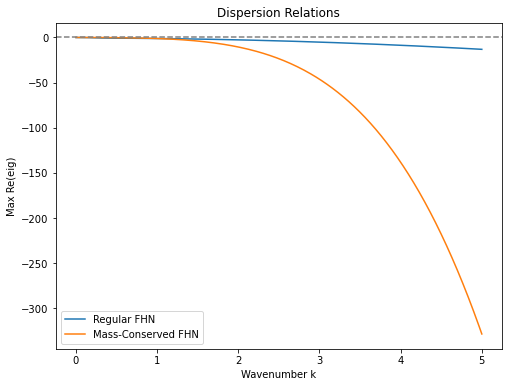

In [20]:
# 2) Fixed-Point & Dispersion
analyze_fp(a, b, epsilon)
u_fp_vals, _ = steady_state_fp(a, b)
u_fp = u_fp_vals[0]
ks = np.linspace(0, 5, 300)
disp_reg = np.array([dispersion_reg(k, u_fp, epsilon, b, Du, Dv) for k in ks])
disp_mc  = np.array([dispersion_mc(k, u_fp, epsilon, b, Du, Dv) for k in ks])
plt.figure(figsize=(8,6))
plt.plot(ks, disp_reg, label='Regular FHN')
plt.plot(ks, disp_mc, label='Mass-Conserved FHN')
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel('Wavenumber k'); plt.ylabel('Max Re(eig)')
plt.title('Dispersion Relations'); plt.legend(); plt.show()

## 5. Robustness Analysis to Noise and Parameter Perturbations
 
Next, we add stochastic noise to the update equations (using an Euler–Maruyama scheme) and compare the final snapshots of the activator u for both models. We run simulations with
different noise amplitudes to see how robust the spatial patterns are.


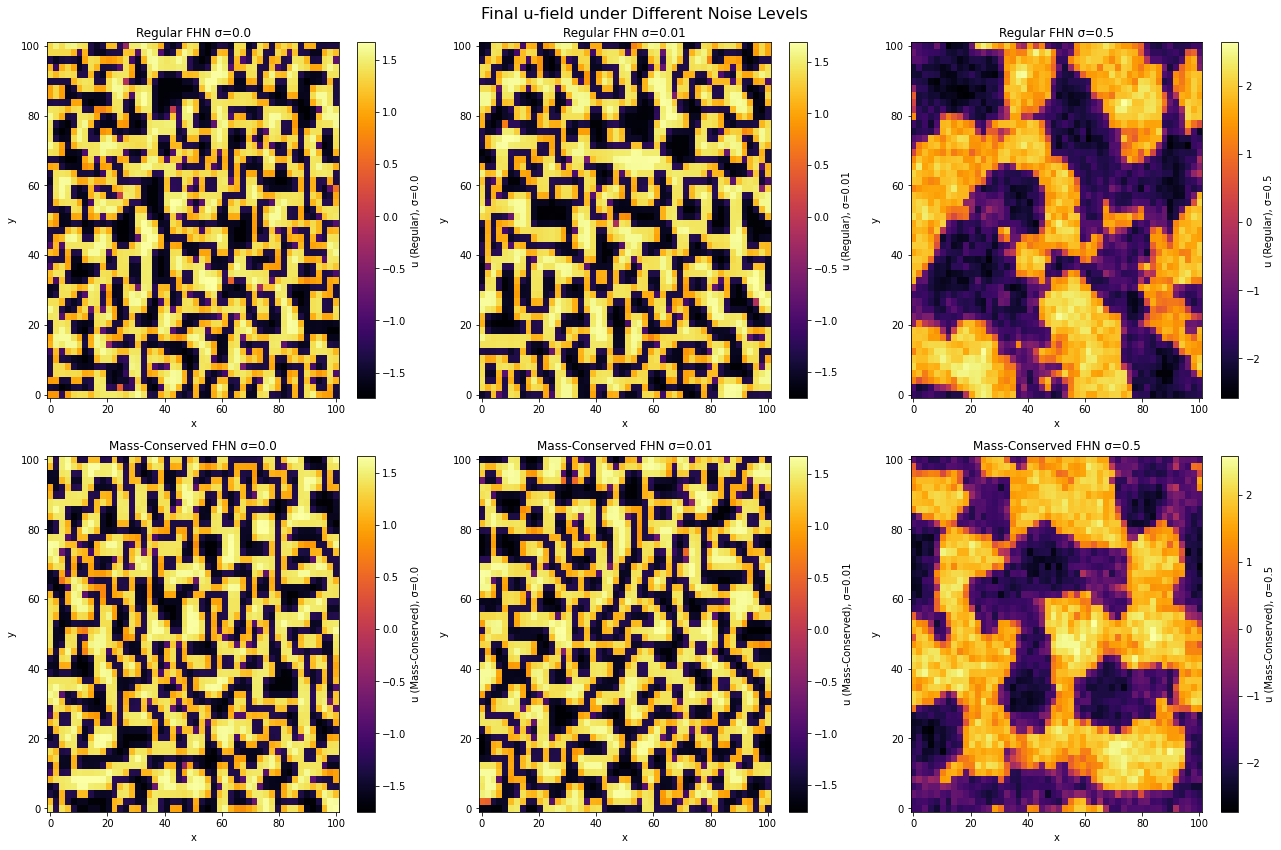

In [23]:
# 3) Noise Study
noise_levels = [0.0, 0.01, 0.5]
final_reg, final_mc = [], []
for sigma in noise_levels:
    _, _, _, u_n, _ = simulate_regular_fhn_noise(T, dt, n_space, domain, a, b, epsilon, Du, Dv, sigma)
    _, _, _, u_mc_n, _ = simulate_regular_fhn_noise(T, dt, n_space, domain, a, b, epsilon, Du, Dv, sigma)
    final_reg.append(u_n[-1]); final_mc.append(u_mc_n[-1])

# Plot noise results
fig, axes = plt.subplots(2, len(noise_levels), figsize=(18,12))
for i, sigma in enumerate(noise_levels):
    ax = axes[0,i]
    plot_field(ax, X_reg, Y_reg, final_reg[i], f'u (Regular), σ={sigma}')
    ax.set_title(f'Regular FHN σ={sigma}')
    ax = axes[1,i]
    plot_field(ax, X_mc, Y_mc, final_mc[i], f'u (Mass-Conserved), σ={sigma}')
    ax.set_title(f'Mass-Conserved FHN σ={sigma}')
plt.suptitle('Final u-field under Different Noise Levels', fontsize=16)
plt.tight_layout(); plt.show()